In [1]:
#default_exp demand

# Demand Forecasting

<br>

### Imports

In [2]:
#exports
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from moepy.lowess import Lowess, quantile_model

from batopt import clean

import os
import FEAutils as hlp

<br>

### User Inputs

In [3]:
raw_data_dir = '../data/raw'
intermediate_data_dir = '../data/intermediate'
cache_data_dir = '../data/nb-cache'

<br>

### Loading Data

In [4]:
df = clean.combine_training_datasets(intermediate_data_dir).interpolate(limit=1)

df.head()

,demand_MW,irradiance_Wm-2,panel_temp_C,pv_power_mw,solar_location1,solar_location2,solar_location3,solar_location4,solar_location5,solar_location6,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6
datetime,,,,,,,,,,,,,,,,
2017-11-03 00:00:00+00:00,2.19,0.0,7.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.560,9.640,7.46,6.680,13.090,13.20
2017-11-03 00:30:00+00:00,2.14,0.0,7.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.625,9.675,7.30,6.475,13.150,13.26
2017-11-03 01:00:00+00:00,2.01,0.0,7.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.690,9.710,7.14,6.270,13.210,13.32
2017-11-03 01:30:00+00:00,1.87,0.0,7.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.715,9.720,7.00,6.090,13.255,13.34
2017-11-03 02:00:00+00:00,1.86,0.0,7.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.740,9.730,6.86,5.910,13.300,13.36


In [5]:
#exports
def construct_df_features(df):
    df_features = df[df.columns[df.columns.str.contains('temp_location')]].copy()

    dts = df_features.index.tz_convert('Europe/London') # We want to use the 'behavioural' timezone

    df_features['weekend'] = dts.dayofweek.isin([5, 6]).astype(int)
    df_features['hour'] = dts.hour + dts.minute/60
    
    return df_features

In [6]:
df_features = construct_df_features(df)

df_features.head()

,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6,weekend,hour
datetime,,,,,,,,
2017-11-03 00:00:00+00:00,8.560,9.640,7.46,6.680,13.090,13.20,0,0.0
2017-11-03 00:30:00+00:00,8.625,9.675,7.30,6.475,13.150,13.26,0,0.5
2017-11-03 01:00:00+00:00,8.690,9.710,7.14,6.270,13.210,13.32,0,1.0
2017-11-03 01:30:00+00:00,8.715,9.720,7.00,6.090,13.255,13.34,0,1.5
2017-11-03 02:00:00+00:00,8.740,9.730,6.86,5.910,13.300,13.36,0,2.0


<br>

### Demand Data Exploratory Analysis

We'll start by exploring the relationship between time of day and demand, in this instance fitting a quantile LOWESS model to get a probabilistic view of likely loads at specific times of day

In [7]:
#exports
def estimate_daily_demand_quantiles(x, y, x_pred = np.linspace(0, 23.5, 100), **model_kwargs):
    # Fitting the model
    df_quantiles = quantile_model(x, y, x_pred=x_pred, **model_kwargs)

    # Cleaning names and sorting for plotting
    df_quantiles.columns = [f'p{int(col*100)}' for col in df_quantiles.columns]
    df_quantiles = df_quantiles[df_quantiles.columns[::-1]]
    
    return df_quantiles

In [8]:
x = df_features['hour'].values
y = df['demand_MW'].values

rerun_daily_demand_model = False
daily_demand_filename = 'daily_demand_quantile_model_results.csv'

if (rerun_daily_demand_model == True) or (daily_demand_filename not in os.listdir(cache_data_dir)):
    df_quantiles = estimate_daily_demand_quantiles(x, y, frac=0.2, num_fits=48, robust_iters=3)
    df_quantiles.to_csv(f'{cache_data_dir}/{daily_demand_filename}')
else:
    df_quantiles = pd.read_csv(f'{cache_data_dir}/{daily_demand_filename}', index_col='x')

df_quantiles.head()

,p90,p80,p70,p60,p50,p40,p30,p20,p10
x,,,,,,,,,
0.000000,2.798489,2.712288,2.646407,2.561911,2.397012,2.106675,1.889666,1.819768,1.770966
0.237374,2.761870,2.675973,2.608709,2.527495,2.369704,2.090690,1.868746,1.795846,1.745769
0.474747,2.725316,2.639735,2.571162,2.493121,2.342462,2.074400,1.847965,1.771846,1.720577
0.712121,2.688708,2.603480,2.533552,2.458632,2.315333,2.057938,1.827455,1.747588,1.695216
0.949495,2.652125,2.567372,2.496137,2.424161,2.288293,2.040857,1.807044,1.723191,1.669598


<br>

We'll now visualise these quantile fits alongside the raw data

N.b. the x values have been slightly jittered in order to make their distribution easier to see

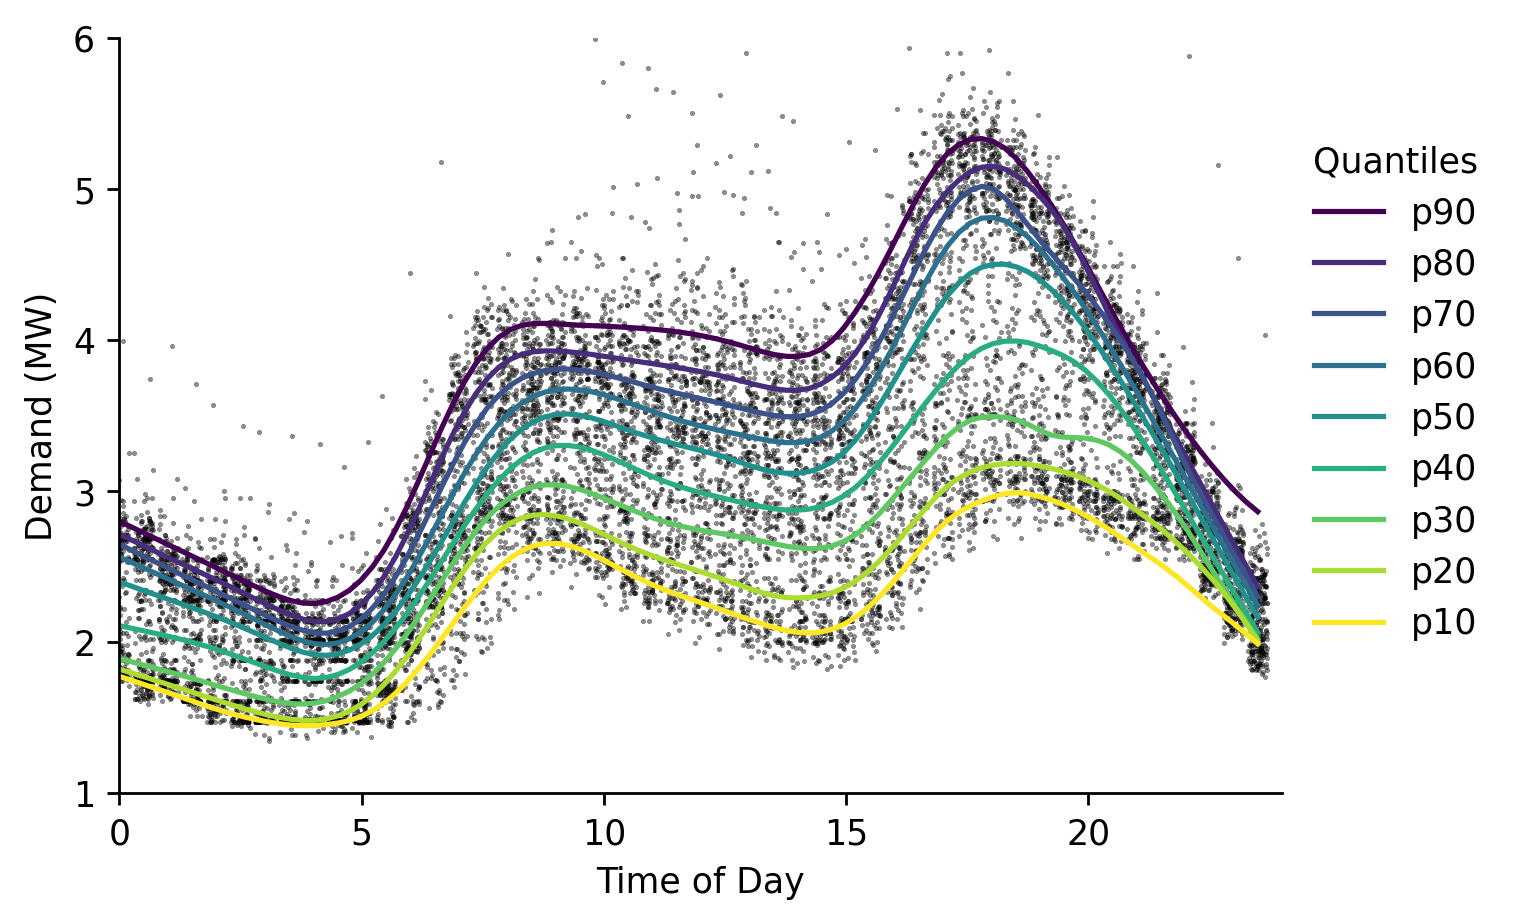

In [9]:
x_jittered = x + (np.random.uniform(size=len(x)) - 0.5)/2.5

# Plotting
fig, ax = plt.subplots(dpi=250)

ax.scatter(x_jittered, y, s=0.2, color='k', alpha=0.5)
df_quantiles.plot(cmap='viridis', legend=False, ax=ax)

hlp.hide_spines(ax)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.9), title='Quantiles')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Demand (MW)')
ax.set_xlim(0, 24)
ax.set_ylim(1, 6)

fig.savefig('../img/daily_demand_profile.png')

<br>

Finally we'll export the relevant code to our `batopt` module

In [10]:
#hide
from nbdev.export import notebook2script
    
notebook2script()

Converted 00-utilities.ipynb.
Converted 01-data-cleaning.ipynb.
Converted 02-demand-forecast.ipynb.
Converted 03-pv-forecast.ipynb.
Converted 04-battery-optimisation.ipynb.
Converted 05-evaluation.ipynb.
Converted 06-pipeline.ipynb.
